# Lecture 11: Simple Random Systems

**Overview:**
* Random walk in 1D.
* Random walk in 2D and entropy.

**Next Lecture:**
* Intro to Monte Carlo, integrating functions in high dimensions.
---

## Tasks
* Modify randwalk() to use purely numpy arrays i.e. *remove the loop over nsamples*.  What sort of performance gain do you achieve with this? *Hint: np.random.randint() can generate array's of arbitrary shape.*

* Modify randwalk() to take random step sizes between 0 and 1. Does the slope of $<x^2>$ vs $n$ change?

In [2]:
#%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

# we will use numba again
from numba import jit
import matplotlib.cm as cm

In [3]:
def randwalk(nsteps = 100, nsamples = 1000):
    nsteps = int(nsteps)
    nsamples = int(nsamples)
    rms = np.zeros(nsteps)
    trajectories = np.zeros([nsamples, nsteps])
    
    # draw a random integer between -1 and 1 for each step, and scale to -0.5 - 0.5
    # exclude first point, becuase we want to start at 0
    
    x0 = np.random.randint(0,1+1, [nsamples,nsteps-1])
    x0 = np.insert(x0, 0, 0, axis = 1)
    
    # take steps
    trajectories = np.cumsum(x0, axis = 1)
    
    # update trajectories array and displacement squared array
    rms=np.sum(trajectories**2, axis = 0)
    
    return rms/nsamples, trajectories


* Once you have created a randwalk method using only numpy array methods and no for loops, use the `%%timeit` function in the cell below to benchmark any performance enhancement.

In [4]:
#%%timeit   # run some timing routines on the current cell, only uncomment for testing purposes, se
nsteps = 500
nsamples = 2e4
rms, trajectories = randwalk(nsteps, nsamples)

Text(0, 0.5, '$x$')

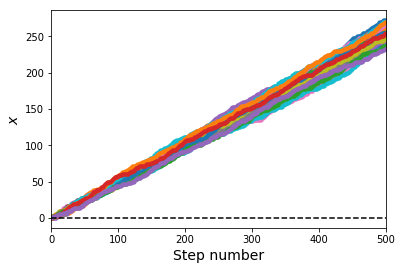

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111)

# plot every 20th trajectory, so the plot is not too crowded
for ii in np.arange(0,len(rms),20):
    ax.plot(trajectories[ii,:],'.-')

# put a horizontal line at y=0
ax.hlines(0,0,1.1*nsteps, linestyles = 'dashed', zorder = 10) #zorder sets the layer order in the plot

ax.set_xlim([0,nsteps])
ax.set_xlabel('Step number', fontsize =14)
ax.set_ylabel('$x$', fontsize = 14)


### Examine the statistics: mean = $<x>$and variance =  $<x^2>$

Below I have set up the a figure with two axes. 

* On the first axis `ax1` plot the mean trajectory.
* On the second axis `ax2` plot the root mean squared (rms) trajectory.
* Find the slope of the rms trajectory by eye.

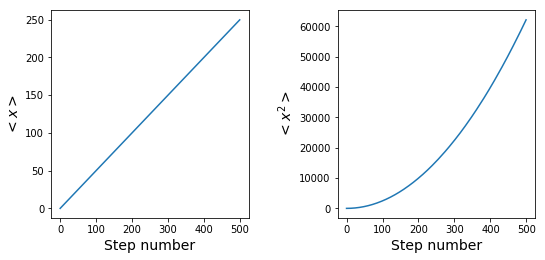

In [6]:
fig = plt.figure(figsize = (8,4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# function to make a straight line
# lambda is a special constructor to create functions on the fly
linear = lambda D, x : 2*D*x

# the above could also be written as 
# def linear(D,x):
#    return 2*D*x

traj = np.sum(trajectories, axis = 0)/trajectories.shape[0]
steps = np.arange(len(rms))

# First plot
ax1.plot(traj)
#ax1.set_ylim([-0.25,0.25])
ax1.set_xlabel('Step number', fontsize =14)
ax1.set_ylabel('$<x>$', fontsize = 14)

# second plot
ax2.plot(rms-traj)
ax2.set_xlabel('Step number', fontsize =14)
ax2.set_ylabel('$<x^2>$', fontsize = 14)

fig.subplots_adjust(left = 0.12,right = 0.96, bottom = 0.14, top = 0.86,wspace =0.45, hspace = 0.35)

plt.show()


### Examine the probability distributions for 1D random walk

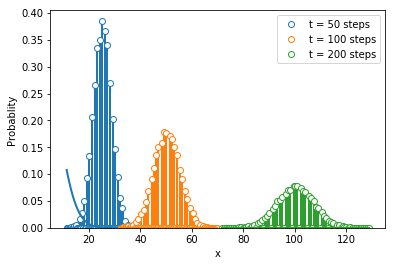

In [7]:
# let's look at the distribution of x for 3 different timepoints

# define a Gaussin function for plotting, use the lambda constructor again
Gaussian = lambda Dt, x : 1/np.sqrt(4*np.pi*Dt)*np.exp(-x**2/(4*Dt))



fig = plt.figure()
ax = fig.add_subplot(111)

# plot P(x) for three differnt timepoints
for ts in [50,100,200]:
    Dt = 0.5*ts
    
    # P(x) is obtained from the histogram over all trajectories at a fixed time point
    n, bins = np.histogram(trajectories[:,ts], bins = 'auto', density = True) 
    
    # histogram returns bin edges, need to extract bin centers for plotting purposes
    bin_center = np.diff(bins)+bins[:-1]

    sf = np.max(n)*np.sqrt(4*np.pi*Dt) # correct scaling for histogram normalization

    # make a bar chart
    ax.bar(bin_center,n)
    
    # also plot points
    # assign the plot object to a variable so we can 'grab' its color
    points, = ax.plot(bin_center,n ,'o', mfc = 'white', label = 't = {} steps'.format(ts))
    
    # plot exact Gaussian with sigma = sqrt(2Dt)
    ax.plot(bin_center, sf*Gaussian(Dt, bin_center), lw = 2, color = points.get_color())

ax.set_ylabel('Probablity')
ax.set_xlabel('x')
ax.legend()
plt.show()


## Random walk in Two-Dimensions
* using numba jit to speed up critical components, there are many loops and simple conditionals here, numba can result in a significant speed up.

* try commenting out the jit decorator around step_2d and see how fast the code runs.

In [3]:
@jit(nopython=True)
def step_2d():
    # step for random walk on 2D square lattice
    d = np.random.randint(1,5)
    if d == 1:
        x_s, y_s = 1, 0
    if d == 2:
        x_s, y_s = 0, 1
    if d == 3:
        x_s, y_s = -1, 0
    if d == 4:
        x_s, y_s = 0, -1
    return [x_s, y_s]


@jit(nopython=True)
def randwalk_2d(nsteps, wall = 1e6):
   # trajectory for a single 2D random walk
    x = np.zeros(nsteps+1, np.double)
    y = np.zeros(nsteps+1, np.double)
    for i in range(nsteps):
        s = step_2d()
        x[i+1] = x[i] + s[0]
        if abs(x[i+1]) > wall: x[i+1] = x[i]
        y[i+1] = y[i] + s[1]
        if abs(y[i+1]) > wall: y[i+1] = y[i]

    return x, y 

@jit(nopython=True)
def ensemble_2d(N,t_max, wall = 1e6):
    #generate an ensemble or random walkers
    xh = np.zeros(N, np.double)
    yh = np.zeros(N, np.double)

    for i in range(N):
        x, y = randwalk_2d(t_max, wall)
        xh[i] = x[-1]
        yh[i] = y[-1]

    return xh, yh



Text(0.5, 1.0, 'Radom walk on 2D square lattice')

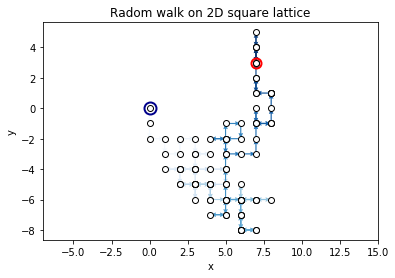

In [4]:
x,y = randwalk_2d(100, wall = 8)

fig = plt.figure()
ax = fig.add_subplot(111)
colormap = cm.Reds
#ax.scatter(x, y, c=np.arange(101), cmap='Reds')
ax.plot(x,y, marker = 'o', ls = 'None', mfc = 'w', mec ='k')
ax.plot(x[0],y[0], marker = 'o', ls = 'None', mfc = 'None', mew = 2, mec ='darkblue', ms = 12)
ax.plot(x[-1],y[-1], marker = 'o', ls = 'None', mfc = 'None', mec ='r', mew = 2, ms =10)

ax.quiver(x[:-1],y[:-1], x[1:]-x[:-1], y[1:]-y[:-1], np.arange(101), cmap = 'Blues', 
          scale = 1, units = 'xy', scale_units = 'xy', width = 0.075, headwidth = 4)
ax.axis('equal')
#ax.set_xlim([-8,8])
#ax.set_ylim([-8,8])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Radom walk on 2D square lattice')

### Generate an ensemble of 2D walkers and coarse-grain to calculate entropy

In [10]:
S = []
ts = np.arange(10,5000,100)
# create coarse grained grid for calculating Probabilities
bin_edge = np.arange(-100,110,10)

# loop over different max times
for t in ts:
    xh, yh = ensemble_2d(N = 500, t_max = t,wall =200)
    # h is counts/bin/total/Area, multiply h by bin area to get a probability
    h, x_edges, y_edges = np.histogram2d(xh,yh, bins = [bin_edge, bin_edge], normed = True)
    
    # calculate entropy, taking care of log(0) with a small number
    S.append(-1*np.sum(100*h*np.log(100*h+1e-40)))

Text(0.5, 1.0, 'Entropy in 2D square lattice')

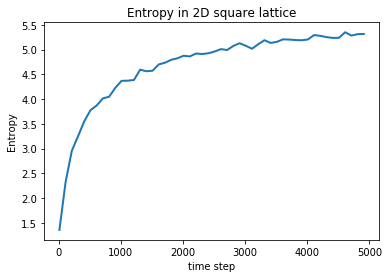

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(ts,S, lw = 2)
ax.set_xlabel('time step')
ax.set_ylabel('Entropy')
ax.set_title("Entropy in 2D square lattice")

In [12]:
# Check that we have a proper probability, should be 1
np.sum(h)*100

1.0000000000000002